# Serotonin transporter ligand exploratory Analysis

<img src="SERT_scheme.png"  width="40%">

In this notebook:

1. Search and cleaning of data
2. Labeling compounds according their activity
3. Converting IC50 (standard_value) to pIC50
4. Calculating 1D descriptors
5. Plot of descriptors and Mann-Whitney U test analysis

In [ ]:
#If you are using colab, you may use this before starting.

! pip install chembl_webresource_client pandas numpy seaborn matplotlib rdkit datamol mols2grid

In [52]:
#Essentials for data handle
import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(color_codes=True)
import matplotlib.pyplot as plt

#Chemistry data handle
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import rdBase
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem import Descriptors

#Other tools
import datamol as dm
import mols2grid

### 1. Search and cleaning of data

It is possible to use chembl_webresource_client to search for protein target keywords. 

```
from chembl_webresource_client.new_client import new_client

# Search for Serotonin transporter (SERT)
target = new_client.target
target_query = target.search('serotonin transporter')
targets = pd.DataFrame.from_dict(target_query)
targets
```
After displaying all the assays available we can choose the target_index, for example: 1.

```
target_index = 1
selected_target = targets.target_chembl_id[target_index]
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target)
Original_SERT_df = pd.DataFrame.from_dict(res)
Original_SERT_df.columns

```

This time I obtain directly the file from ChemBL to save time, this process can take between 5-10 min.

In [2]:
#loading CSV file and first look at the data
Original_SERT_df = pd.read_csv('SERT_data_CheMBL.csv', sep=';')
Original_SERT_df.head()


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type
0,CHEMBL419336,NaN,NaN,499.56,0.0,3.81,2d,COc1cc2c(cc1OC)C1=NO[C@@H](CN3CCN(C/C(C)=C/c4c...,Ki,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1146766,1,Scientific Literature,Bioorg Med Chem Lett,2004.0,NaN,NaN,NaN
1,CHEMBL402851,NaN,NaN,261.75,0.0,4.19,10,CN(C)Cc1ccccc1Oc1ccccc1Cl,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1141595,1,Scientific Literature,Bioorg Med Chem Lett,2008.0,CHEMBL3307715,NaN,NaN
2,CHEMBL256816,NaN,NaN,282.17,0.0,4.51,18,CNCc1ccccc1Oc1ccc(Cl)cc1Cl,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1141595,1,Scientific Literature,Bioorg Med Chem Lett,2008.0,CHEMBL3307715,NaN,NaN
3,CHEMBL1170212,NaN,NaN,292.39,0.0,2.58,15,c1ccc(CC2CNCCN2c2cnc3[nH]ccc3c2)cc1,Ki,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1177766,1,Scientific Literature,Bioorg Med Chem Lett,2010.0,CHEMBL3307715,NaN,NaN
4,CHEMBL560535,NaN,NaN,305.42,0.0,3.93,4,c1ccc(CN(c2ccc3[nH]ccc3c2)C2CCNCC2)cc1,Ki,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1177766,1,Scientific Literature,Bioorg Med Chem Lett,2010.0,CHEMBL3307715,NaN,NaN


In [ ]:
Original_SERT_df.columns

In [3]:
SERT_df = Original_SERT_df[['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units']]

#Making copy to not have issues with overwriting dataframe
SERT_df1 = SERT_df.copy()

#To avoid problem with mols2grid, it is recomended to convert Smiles -> SMILES
SERT_df1.rename(columns={'Smiles': 'SMILES'}, inplace=True)

#to work with the standard values it is better to change to a one string name

SERT_df1.rename(columns={'Standard Value': 'standard_value'}, inplace=True)

SERT_df1.head()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,standard_value,Standard Units
0,CHEMBL419336,COc1cc2c(cc1OC)C1=NO[C@@H](CN3CCN(C/C(C)=C/c4c...,Ki,'=',7.1000,nM
1,CHEMBL402851,CN(C)Cc1ccccc1Oc1ccccc1Cl,IC50,'=',282.0000,nM
2,CHEMBL256816,CNCc1ccccc1Oc1ccc(Cl)cc1Cl,IC50,'=',56.0000,nM
3,CHEMBL1170212,c1ccc(CC2CNCCN2c2cnc3[nH]ccc3c2)cc1,Ki,'=',63.1000,nM
4,CHEMBL560535,c1ccc(CN(c2ccc3[nH]ccc3c2)C2CCNCC2)cc1,Ki,'=',0.7943,nM


In [4]:
#droping NA
SERT_df1= SERT_df1.dropna()

In [5]:
#Looking for duplicate entries
SERT_df1['Molecule ChEMBL ID'].value_counts()

Molecule ChEMBL ID
CHEMBL41         60
CHEMBL370805     54
CHEMBL11         32
CHEMBL1175       21
CHEMBL549        20
                 ..
CHEMBL3639720     1
CHEMBL3673169     1
CHEMBL3673154     1
CHEMBL3673150     1
CHEMBL5180373     1
Name: count, Length: 5968, dtype: int64

In [6]:
#Looking for kind of activity measurements available in the data set

SERT_df1['Standard Type'].value_counts()

Standard Type
IC50               3562
Ki                 3166
Inhibition          778
EC50                156
Activity            102
T1/2                 30
Kd                   23
ED50                 20
INH                  11
IC5                  10
Efficacy              5
Displacement          2
% of inhibition       2
% Ctrl                2
Bmax                  1
Kinact                1
Kb                    1
Name: count, dtype: int64

In [15]:
#To not mix the kind of measurements and units I chosed to keep IC50 in nM. Then inhibitor potency will be analysed.
SERT_df2=SERT_df1[SERT_df1['Standard Units'].str.contains('nM')]

In [16]:
#Units of the activity measurements
SERT_df2['Standard Units'].value_counts()

Standard Units
nM    6950
Name: count, dtype: int64

In [17]:
SERT_df3=SERT_df2[SERT_df2['Standard Type'].str.contains('IC50')]

In [19]:
#Sorting all the values to then keep the lowest IC50 values
SERT_df3 = SERT_df3.sort_values('standard_value', ascending=True)
SERT_df3 = SERT_df3.drop_duplicates('Molecule ChEMBL ID', keep='first')

In [20]:
SERT_df3.head()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,standard_value,Standard Units
4337,CHEMBL1762471,CNCC[C@@H](Oc1cc(Cl)ccc1Cl)c1ccccc1.O=C(O)/C=C...,IC50,'=',0.000,nM
7646,CHEMBL490,Fc1ccc([C@@H]2CCNC[C@H]2COc2ccc3c(c2)OCO3)cc1,IC50,'=',0.080,nM
2142,CHEMBL415,CN(C)CCCN1c2ccccc2CCc2ccc(Cl)cc21,IC50,'=',0.088,nM
4946,CHEMBL83617,NC(=O)c1ccc2c(c1)CCOC2CCN1CC=C(c2c[nH]c3cc(F)c...,IC50,'=',0.110,nM
7097,CHEMBL552167,CN(C)C[C@H]1CCC[C@@H]1c1c[nH]c2ccc(C#N)cc12,IC50,'=',0.130,nM


In [21]:
#Lastly, it is necessary to drop the SMILES structures that contain 2 or more molecules eg. salts, isomers that come together or in complex with molecules such as oxalic acid. They can be found with the pattern "."

#Creating a separate dataframe for the not desirable entries
not_desired_df = SERT_df3.copy()
not_desired_df = not_desired_df[not_desired_df['SMILES'].str.contains(r'\.', na=False)]
not_desired_df.shape

(310, 6)

In [22]:
not_desired_df.head()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,standard_value,Standard Units
4337,CHEMBL1762471,CNCC[C@@H](Oc1cc(Cl)ccc1Cl)c1ccccc1.O=C(O)/C=C...,IC50,'=',0.00,nM
1787,CHEMBL3216076,Cc1cccc(N2CCN(C[C@H](O)CNC(=O)c3nc(C)n(-c4cccc...,IC50,'=',0.64,nM
8342,CHEMBL3216077,Cc1cccc(N2CCN(C[C@H](O)CNC(=O)c3nc(C)n(-c4cccc...,IC50,'=',0.75,nM
3798,CHEMBL2112075,CC(C)(Cc1ccc2ccccc2c1)NC[C@@H](O)COc1cccc(Cl)c...,IC50,'=',2.00,nM
4711,CHEMBL2407328,COCC(c1ccc2ccccc2c1)C1CCNCC1.Cl,IC50,'=',2.10,nM


In [23]:
#Creating visualization to look how not desired structures looks like
mols2grid.display(not_desired_df, subset=['Molecule ChEMBL ID'])

MolGridWidget()

In [24]:
#With the indexes, those molecules will be droped from the main dataframe
not_desired_indexes = list(not_desired_df.index.values)
SERT_df3.drop(index=not_desired_indexes, inplace = True)

In [25]:
SERT_df3.shape

(2768, 6)

In [26]:
SERT_df3.head()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,standard_value,Standard Units
7646,CHEMBL490,Fc1ccc([C@@H]2CCNC[C@H]2COc2ccc3c(c2)OCO3)cc1,IC50,'=',0.080,nM
2142,CHEMBL415,CN(C)CCCN1c2ccccc2CCc2ccc(Cl)cc21,IC50,'=',0.088,nM
4946,CHEMBL83617,NC(=O)c1ccc2c(c1)CCOC2CCN1CC=C(c2c[nH]c3cc(F)c...,IC50,'=',0.110,nM
7097,CHEMBL552167,CN(C)C[C@H]1CCC[C@@H]1c1c[nH]c2ccc(C#N)cc12,IC50,'=',0.130,nM
4632,CHEMBL809,CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc21,IC50,'=',0.141,nM


In [28]:
SERT_df3.tail()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,standard_value,Standard Units
9964,CHEMBL4786386,O=C(CN1CCN(C(=O)c2cccc(Cl)c2)CC1)N1CCN(CCCc2c[...,IC50,'>',1000000.0,nM
9963,CHEMBL4800589,O=C(CN1CCN(C(=O)c2ccc(Br)cc2)CC1)N1CCN(CCCc2c[...,IC50,'>',1000000.0,nM
9307,CHEMBL4782574,COc1ccc(C(=O)N2CCN(CC(=O)N3CCN(CCCc4c[nH]c5ccc...,IC50,'>',1000000.0,nM
4757,CHEMBL4788937,COc1ccc2[nH]cc(CCCN3CCN(C(=O)CN4CCN(C(=O)c5ccc...,IC50,'>',1000000.0,nM
4758,CHEMBL4785452,COc1ccc2[nH]cc(CCCN3CCN(C(=O)CN4CCN(C(=O)c5ccc...,IC50,'>',1000000.0,nM


In [29]:
Original_SERT_df.shape

(10406, 46)

In [30]:
SERT_df3.shape

(2768, 6)

### Summary: 
 - Original data set was reduced from 10406 to 2768 molecules entries.
 - Missing data was droped
 - undesired SMILES codes were droped
 - Only IC50 in nM entries were selected

### 2. Labeling compounds according their activity

In [33]:
SERT_df_clean = SERT_df3.copy()
SERT_df_clean= SERT_df_clean.reset_index(drop=True)
SERT_df_clean.shape

(2768, 6)

In [34]:
#Labeling compounds as active, inactive or intermediate 

# Active --> < 1000nM
# Intermediate --> 1000 nM > x > 10.000 nM
# Inactive  --> > 10.000

activity_threshold = []

for ai in SERT_df_clean.standard_value:
    if float(ai) >= 10000:
        activity_threshold.append('inactive')
    elif float(ai) <= 1000:
        activity_threshold.append('active')
    else:
        activity_threshold.append('intermediate')


In [36]:
activity_class = pd.Series(activity_threshold, name='class')
SERT_df_clean = pd.concat([SERT_df_clean, activity_class], axis=1)
SERT_df_clean.head()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,standard_value,Standard Units,class
0,CHEMBL490,Fc1ccc([C@@H]2CCNC[C@H]2COc2ccc3c(c2)OCO3)cc1,IC50,'=',0.080,nM,active
1,CHEMBL415,CN(C)CCCN1c2ccccc2CCc2ccc(Cl)cc21,IC50,'=',0.088,nM,active
2,CHEMBL83617,NC(=O)c1ccc2c(c1)CCOC2CCN1CC=C(c2c[nH]c3cc(F)c...,IC50,'=',0.110,nM,active
3,CHEMBL552167,CN(C)C[C@H]1CCC[C@@H]1c1c[nH]c2ccc(C#N)cc12,IC50,'=',0.130,nM,active
4,CHEMBL809,CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc21,IC50,'=',0.141,nM,active


In [37]:
SERT_df_clean.tail()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,standard_value,Standard Units,class
2763,CHEMBL4786386,O=C(CN1CCN(C(=O)c2cccc(Cl)c2)CC1)N1CCN(CCCc2c[...,IC50,'>',1000000.0,nM,inactive
2764,CHEMBL4800589,O=C(CN1CCN(C(=O)c2ccc(Br)cc2)CC1)N1CCN(CCCc2c[...,IC50,'>',1000000.0,nM,inactive
2765,CHEMBL4782574,COc1ccc(C(=O)N2CCN(CC(=O)N3CCN(CCCc4c[nH]c5ccc...,IC50,'>',1000000.0,nM,inactive
2766,CHEMBL4788937,COc1ccc2[nH]cc(CCCN3CCN(C(=O)CN4CCN(C(=O)c5ccc...,IC50,'>',1000000.0,nM,inactive
2767,CHEMBL4785452,COc1ccc2[nH]cc(CCCN3CCN(C(=O)CN4CCN(C(=O)c5ccc...,IC50,'>',1000000.0,nM,inactive


### 3. Converting IC50 (standard_value) to pIC50

- To obtain data uniformly distributed, custom function must be applied
    1. values greater than 10^8 will be fixed to 10^8 to avoid negative logarithmic values (if applicable)
    2. nM units will be converted to M
    3. -log10 is applied
    4. delete the standard_value colum and replace it by pIC50

In [31]:
# 1.Normalize values greater than 10^8

def norm_value(input_value):
    norm = []

    for ai in input_value['standard_value']:
        if float(ai) > 100000000:
            ai = 100000000
        norm.append(ai)

    input_value['standard_value_norm'] = norm
    #updated_df = input_value.drop('standard_value', 1)

    return input_value #updated_df

# 2. convert IC50 --> pIC50 values 

def IC50_to_pIC50(input_value):
    pIC50 = []
    
    for ai in input_value['standard_value_norm']:
        molar_value = ai*(10**-9) #nM-->M
        pIC50.append(-np.log10(molar_value))

    input_value['pIC50'] = pIC50
    #updated_df = input_value.drop(['standard_value','standard_value_norm', 'Standard Units', 'Standard Relation', 'Standard Type'],1)

    return input_value

In [38]:
SERT_df_clean.standard_value.describe()

count       2768.000000
mean       12813.303257
std        93476.129800
min            0.080000
25%           17.475000
50%          150.000000
75%         1592.500000
max      1000000.000000
Name: standard_value, dtype: float64

In [39]:
SERT_df_norm = norm_value(SERT_df_clean)
SERT_df_norm.standard_value.describe()

count       2768.000000
mean       12813.303257
std        93476.129800
min            0.080000
25%           17.475000
50%          150.000000
75%         1592.500000
max      1000000.000000
Name: standard_value, dtype: float64

There was no need for the norm_value function since the max value is lower than 10^8, but it was applied as an example for the rutinary analysis.

In [40]:
SERT_df_inshape = IC50_to_pIC50(SERT_df_norm)
SERT_df_inshape.head()

,Molecule ChEMBL ID,SMILES,Standard Type,Standard Relation,standard_value,Standard Units,class,standard_value_norm,pIC50
0,CHEMBL490,Fc1ccc([C@@H]2CCNC[C@H]2COc2ccc3c(c2)OCO3)cc1,IC50,'=',0.080,nM,active,0.080,10.096910
1,CHEMBL415,CN(C)CCCN1c2ccccc2CCc2ccc(Cl)cc21,IC50,'=',0.088,nM,active,0.088,10.055517
2,CHEMBL83617,NC(=O)c1ccc2c(c1)CCOC2CCN1CC=C(c2c[nH]c3cc(F)c...,IC50,'=',0.110,nM,active,0.110,9.958607
3,CHEMBL552167,CN(C)C[C@H]1CCC[C@@H]1c1c[nH]c2ccc(C#N)cc12,IC50,'=',0.130,nM,active,0.130,9.886057
4,CHEMBL809,CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc21,IC50,'=',0.141,nM,active,0.141,9.850781


In [43]:
#Removing not useful columns from df

SERT_explore_analysis = SERT_df_inshape[['Molecule ChEMBL ID', 'SMILES', 'class', 'pIC50']]
SERT_explore_analysis.head()

,Molecule ChEMBL ID,SMILES,class,pIC50
0,CHEMBL490,Fc1ccc([C@@H]2CCNC[C@H]2COc2ccc3c(c2)OCO3)cc1,active,10.096910
1,CHEMBL415,CN(C)CCCN1c2ccccc2CCc2ccc(Cl)cc21,active,10.055517
2,CHEMBL83617,NC(=O)c1ccc2c(c1)CCOC2CCN1CC=C(c2c[nH]c3cc(F)c...,active,9.958607
3,CHEMBL552167,CN(C)C[C@H]1CCC[C@@H]1c1c[nH]c2ccc(C#N)cc12,active,9.886057
4,CHEMBL809,CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc21,active,9.850781


### 4. Calculating 1D descriptors

In [41]:
def max_ring_size(mol):
    """Get the size of the largest ring in a molecule

    - mol: input_molecule
    - return: size of the largest ring or 0 for an acyclic molecule

    """
    
    ri = mol.GetRingInfo()
    atom_rings = ri.AtomRings()
    if len(atom_rings) == 0:
        return 0
    else:
        return max([len(x) for x in ri.AtomRings()])
    

SERT_prop_dict = {
    "Mw" : dm.descriptors.mw,
    "logP" : dm.descriptors.clogp,
    "HBd" : dm.descriptors.n_lipinski_hbd,
    "HBa" : dm.descriptors.n_lipinski_hba,
    "Max_ring_size" : max_ring_size
}

In [44]:
#obtaining RDkit molecule objects

SERT_explore_analysis['mol'] = dm.from_df(SERT_explore_analysis, smiles_column='SMILES')
SERT_explore_analysis.head()

/var/folders/cd/_gflzb8s6fd89mb08fzvv4z80000gn/T/ipykernel_29687/2581497202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SERT_explore_analysis['mol'] = dm.from_df(SERT_explore_analysis, smiles_column='SMILES')


,Molecule ChEMBL ID,SMILES,class,pIC50,mol
0,CHEMBL490,Fc1ccc([C@@H]2CCNC[C@H]2COc2ccc3c(c2)OCO3)cc1,active,10.096910,<rdkit.Chem.rdchem.Mol object at 0x7fc2d8dff7d0>
1,CHEMBL415,CN(C)CCCN1c2ccccc2CCc2ccc(Cl)cc21,active,10.055517,<rdkit.Chem.rdchem.Mol object at 0x7fc2c9f497e0>
2,CHEMBL83617,NC(=O)c1ccc2c(c1)CCOC2CCN1CC=C(c2c[nH]c3cc(F)c...,active,9.958607,<rdkit.Chem.rdchem.Mol object at 0x7fc2c9f49850>
3,CHEMBL552167,CN(C)C[C@H]1CCC[C@@H]1c1c[nH]c2ccc(C#N)cc12,active,9.886057,<rdkit.Chem.rdchem.Mol object at 0x7fc2c9f498c0>
4,CHEMBL809,CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc21,active,9.850781,<rdkit.Chem.rdchem.Mol object at 0x7fc2c9f49930>


In [45]:
SERT_prop_df = dm.descriptors.batch_compute_many_descriptors(SERT_explore_analysis.mol, properties_fn=SERT_prop_dict ,add_properties=False, progress=True)

  0%|          | 0/2768 [00:00<?, ?it/s]

In [46]:
SERT_prop_df.head()


,Mw,logP,HBd,HBa,Max_ring_size
0,329.142722,3.32650,1,4,6
1,314.154976,4.52840,0,2,7
2,419.200905,4.19910,3,5,6
3,267.173548,3.48488,1,3,6
4,305.073805,5.17960,1,1,6


In [47]:
SERT_prop_clean_df = pd.concat([SERT_explore_analysis,SERT_prop_df],axis=1)
SERT_prop_clean_df.shape

(2768, 10)

In [48]:
SERT_prop_clean_df.head()

,Molecule ChEMBL ID,SMILES,class,pIC50,mol,Mw,logP,HBd,HBa,Max_ring_size
0,CHEMBL490,Fc1ccc([C@@H]2CCNC[C@H]2COc2ccc3c(c2)OCO3)cc1,active,10.096910,<rdkit.Chem.rdchem.Mol object at 0x7fc2d8dff7d0>,329.142722,3.32650,1,4,6
1,CHEMBL415,CN(C)CCCN1c2ccccc2CCc2ccc(Cl)cc21,active,10.055517,<rdkit.Chem.rdchem.Mol object at 0x7fc2c9f497e0>,314.154976,4.52840,0,2,7
2,CHEMBL83617,NC(=O)c1ccc2c(c1)CCOC2CCN1CC=C(c2c[nH]c3cc(F)c...,active,9.958607,<rdkit.Chem.rdchem.Mol object at 0x7fc2c9f49850>,419.200905,4.19910,3,5,6
3,CHEMBL552167,CN(C)C[C@H]1CCC[C@@H]1c1c[nH]c2ccc(C#N)cc12,active,9.886057,<rdkit.Chem.rdchem.Mol object at 0x7fc2c9f498c0>,267.173548,3.48488,1,3,6
4,CHEMBL809,CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc21,active,9.850781,<rdkit.Chem.rdchem.Mol object at 0x7fc2c9f49930>,305.073805,5.17960,1,1,6


### 5. Plot of descriptors and Mann-Whitney U test analysis

1. The data set will be filtered according to the Lipinski's rule of 5 for ADTME.

In [58]:
SERT_lipinski_df = SERT_prop_clean_df.copy()

SERT_lipinski_df['ro5_ok'] = (SERT_lipinski_df.Mw <= 500) & (SERT_lipinski_df.logP <=5) & (SERT_lipinski_df.HBd <= 5) & (SERT_lipinski_df.HBa <= 10)
SERT_lipinski_df.ro5_ok.sum()


def bool_to_int(bool_in):
    return bool_in.values.astype(int)

SERT_lipinski_df['ro5_count'] = bool_to_int(SERT_lipinski_df.Mw <= 500) + bool_to_int(SERT_lipinski_df.logP <=5) + bool_to_int(SERT_lipinski_df.HBd <= 5) + bool_to_int(SERT_lipinski_df.HBa <= 10)

len(SERT_lipinski_df.query("ro5_count == 4"))

2098

In [65]:
SERT_lipinski_df.head()

,Molecule ChEMBL ID,SMILES,class,pIC50,mol,Mw,logP,HBd,HBa,Max_ring_size,ro5_ok,ro5_count
0,CHEMBL490,Fc1ccc([C@@H]2CCNC[C@H]2COc2ccc3c(c2)OCO3)cc1,active,10.096910,<rdkit.Chem.rdchem.Mol object at 0x7fc2d8dff7d0>,329.142722,3.32650,1,4,6,True,4
1,CHEMBL415,CN(C)CCCN1c2ccccc2CCc2ccc(Cl)cc21,active,10.055517,<rdkit.Chem.rdchem.Mol object at 0x7fc2c9f497e0>,314.154976,4.52840,0,2,7,True,4
2,CHEMBL83617,NC(=O)c1ccc2c(c1)CCOC2CCN1CC=C(c2c[nH]c3cc(F)c...,active,9.958607,<rdkit.Chem.rdchem.Mol object at 0x7fc2c9f49850>,419.200905,4.19910,3,5,6,True,4
3,CHEMBL552167,CN(C)C[C@H]1CCC[C@@H]1c1c[nH]c2ccc(C#N)cc12,active,9.886057,<rdkit.Chem.rdchem.Mol object at 0x7fc2c9f498c0>,267.173548,3.48488,1,3,6,True,4
4,CHEMBL809,CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc21,active,9.850781,<rdkit.Chem.rdchem.Mol object at 0x7fc2c9f49930>,305.073805,5.17960,1,1,6,False,3



#### A. Frequency of activity clases

/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

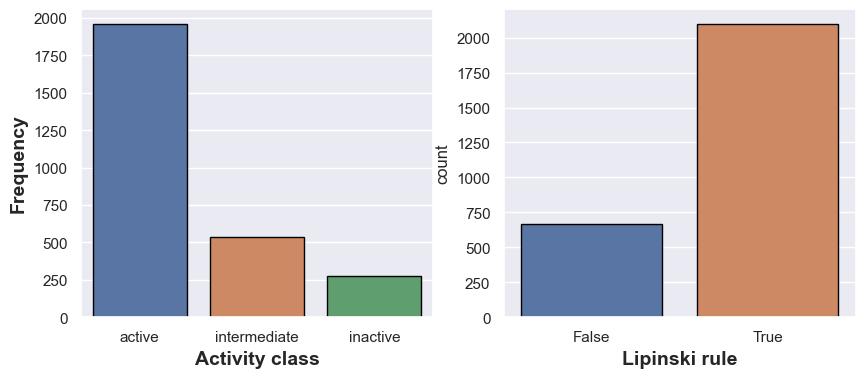

In [68]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)

sns.countplot(x='class', data=SERT_prop_clean_df, edgecolor='black')
plt.xlabel('Activity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
#plt.savefig('plot_activity_class.pdf')

plt.subplot(1,2,2)

sns.countplot(x='ro5_ok', data=SERT_lipinski_df, edgecolor='black')
plt.xlabel('Lipinski rule', fontsize=14, fontweight='bold')
#plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_activity_class_lipinski.pdf')

#### B. Scatter plot of Mw vs logP

/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

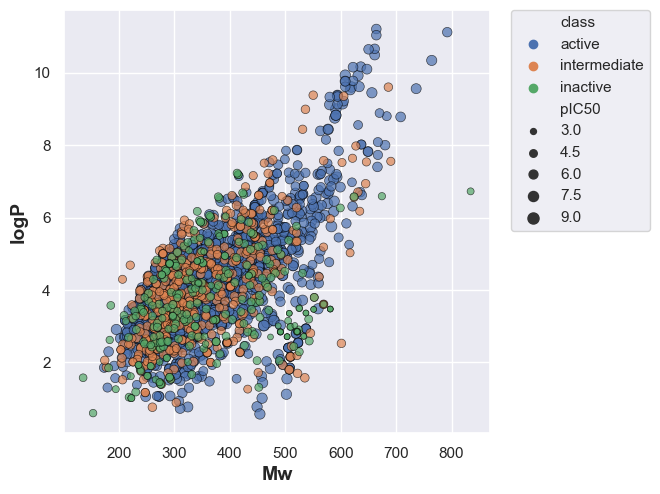

In [54]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='Mw', y='logP', data=SERT_prop_clean_df, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('Mw', fontsize=14, fontweight='bold')
plt.ylabel('logP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_Mw_vs_logP.pdf')

#### C. pIC50 values according to activity classes

/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


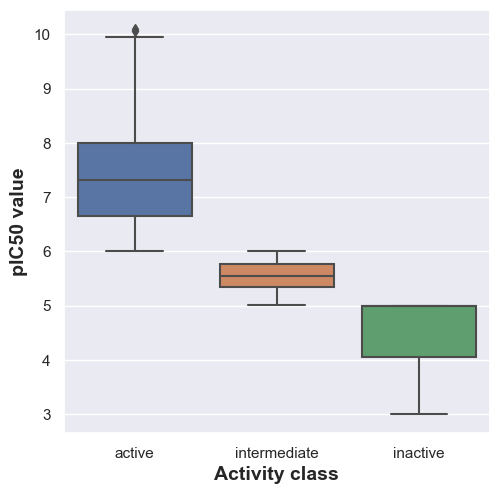

In [67]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = SERT_lipinski_df)

plt.xlabel('Activity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

#### D. Mw values according to activity clases

/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


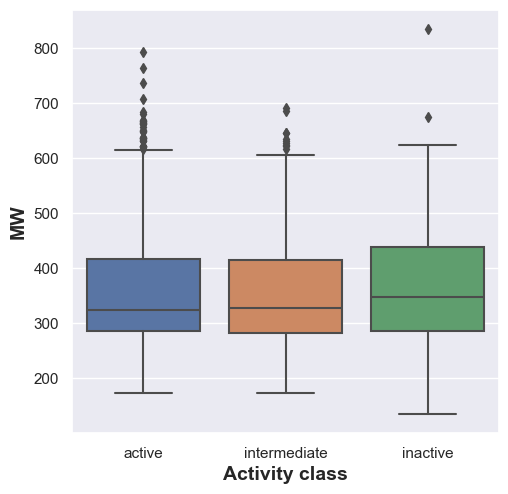

In [69]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'Mw', data = SERT_lipinski_df)

plt.xlabel('Activity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_Mw.pdf')

#### E. logP vs activity clases

/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


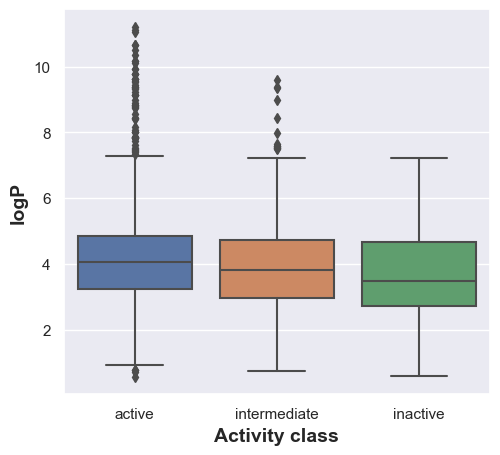

In [75]:
plt.figure(figsize=(5.5, 5))

sns.boxplot(x = 'class', y = 'logP', data = SERT_lipinski_df)

plt.xlabel('Activity class', fontsize=14, fontweight='bold')
plt.ylabel('logP', fontsize=14, fontweight='bold')

plt.savefig('plot_logP.pdf')

#### F. H donors and Acceptors vs activity clases

/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mon/opt/anaconda3/envs/ChemBioML/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

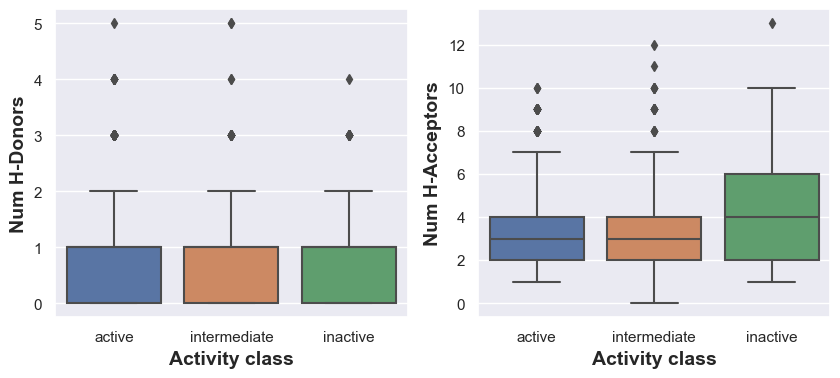

In [76]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)

sns.boxplot(x = 'class', y = 'HBd', data = SERT_lipinski_df)
plt.xlabel('Activity class', fontsize=14, fontweight='bold')
plt.ylabel('Num H-Donors', fontsize=14, fontweight='bold')

plt.subplot(1,2,2)
sns.boxplot(x = 'class', y = 'HBa', data = SERT_lipinski_df)
plt.xlabel('Activity class', fontsize=14, fontweight='bold')
plt.ylabel('Num H-Acceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumH-Acceptors_Donors.pdf')

#plt.savefig('plot_NumH-Donors.pdf')

### Statistical Analysis (Mann-Whinet U test)

In [79]:
def mannwhitney(descriptor, my_df, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = my_df[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = my_df[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [80]:
mannwhitney('pIC50', SERT_lipinski_df)

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,535353.0,2.381104e-158,0.05,Different distribution (reject H0)


In [82]:
mannwhitney('Mw', SERT_lipinski_df)

,Descriptor,Statistics,p,alpha,Interpretation
0,Mw,248636.0,0.05655,0.05,Same distribution (fail to reject H0)


In [83]:
mannwhitney('logP', SERT_lipinski_df)

,Descriptor,Statistics,p,alpha,Interpretation
0,logP,318789.0,3.077435e-07,0.05,Different distribution (reject H0)


In [84]:
mannwhitney('HBd', SERT_lipinski_df)

,Descriptor,Statistics,p,alpha,Interpretation
0,HBd,307421.5,0.00002,0.05,Different distribution (reject H0)


In [85]:
mannwhitney('HBa', SERT_lipinski_df)

,Descriptor,Statistics,p,alpha,Interpretation
0,HBa,221906.0,0.000003,0.05,Different distribution (reject H0)


### Saving files for future analysis

In [88]:
SERT_lipinski_df.columns

Index(['Molecule ChEMBL ID', 'SMILES', 'class', 'pIC50', 'mol', 'Mw', 'logP',
       'HBd', 'HBa', 'Max_ring_size', 'ro5_ok', 'ro5_count'],
      dtype='object')

In [89]:
#Saving all the columns exepting "mol" RDkit objects

My_comlumns = ['Molecule ChEMBL ID', 'SMILES', 'class', 'pIC50', 'Mw', 'logP',
       'HBd', 'HBa', 'Max_ring_size', 'ro5_ok', 'ro5_count']
SERT_final_df = SERT_lipinski_df[My_comlumns]

SERT_final_df.to_csv('SERT_properties_clean_dataset.csv', index=None)